## Assignment 2 - Daniel Adunas

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
#ml4s.set_css_style('./ml4s/include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Feature mapping and linear regression work is located in A02 folder. 

## Radioactive Decay

In [81]:
!head decay.dat

#       time [s]	 Num Atoms [Arb.]       +/- [Arb.]
               5	          317               18
              45	          276               18
              85	          307	            17
             125	          273	            17
             165	          237	            16
             205	          225	            16
             245	          226	            16
             285	          204	            15
             325	          223	            15


Text(0, 0.5, 'N(t)')

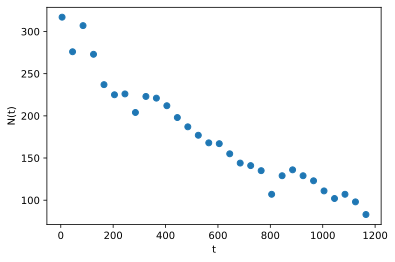

In [82]:
t,N,σ = np.loadtxt('decay.dat',unpack=True)
plt.plot(t,N, 'o')
plt.xlabel('t')
plt.ylabel('N(t)')

In [83]:
#ln(Nt) = ln(N0) - t/τ
y = np.log(N)

In [84]:
poly_order = 1
Φ = np.zeros([len(t),poly_order+1])
for j in range(Φ.shape[1]):
    Φ[:,j] = t**j

In [85]:
W_opt = np.dot(np.dot(np.linalg.inv(np.dot(Φ.T,Φ)),Φ.T),y)
C_opt = 0.5*np.average((np.dot(Φ,W_opt)-y)**2)

print(f'W_opt = {W_opt}')
print(f'C_opt = {C_opt}')

W_opt = [ 5.70684880e+00 -1.01264481e-03]
C_opt = 0.002406288856152599


In [86]:
N0 = np.exp(W_opt[0])
print('N0 =',N0)

N0 = 300.92130953612656


In [87]:
τ = -(W_opt[1])**-1
print('τ =',τ)

τ = 987.5130816335112


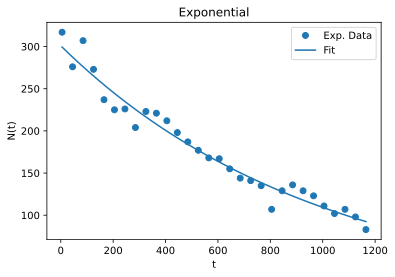

In [88]:
#plt.errorbar(x,T,ΔT,marker='o', linestyle='', label='Exp. Data')
plt.plot(t,N,marker='o', linestyle='', label='Exp. Data')

x_fit = np.linspace(np.min(t),np.max(t),100)
X_fit = np.zeros([x_fit.shape[0],2])
X_fit[:,0] = 1
X_fit[:,1] = x_fit

F = np.exp(W_opt[0] + x_fit*W_opt[1])
#F = N0*(np.exp(-x_fit/τ))
plt.plot(x_fit, F, color=colors[0], label='Fit' )

plt.xlabel('t')
plt.ylabel('N(t)')
plt.title('Exponential')
plt.legend()

In [89]:
N_half = np.log(2)*τ
print('Half-life is',N_half)

Half-life is 684.4919083003314


This nucleus appears to be Polonium-200, with a determined half-life of 690 seconds. 

## Non-Linear Curve Fitting via Gradient Descent

In [11]:
import jax.numpy as jnp 
from jax import grad
from IPython import display
π = np.pi

In [12]:
!head C60_nmr.dat

# Ch Shift [ppm]         Intensity [arb]
      4.94240036	     -0.00341535
      5.34654062	      0.01362526
      5.48103393	     -0.01352983
      5.72144358	     -0.02962094
      5.97842725	     -0.10792436
      6.30495735	      0.08369806
      6.45551406	      0.00789721
      6.79061605	      0.02323168
      6.97147558	      0.04645734


Text(0, 0.5, 'S(δ)')

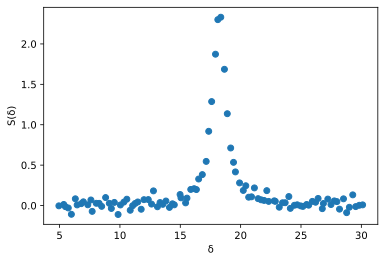

In [13]:
δ,S = np.loadtxt('C60_nmr.dat',unpack=True)
plt.plot(δ, S, 'o')
plt.xlabel('δ')
plt.ylabel('S(δ)')

In [14]:
def Lorentz(δ,w):
    #α = w0, β = w1
    f = 1.0/((δ-w[0])**2 + w[1])
    return f

In [15]:
def C(w,δ,S):
    return 0.5*jnp.average((Lorentz(δ,w)-S)**2)
    
dC_dw = grad(C,argnums=0)

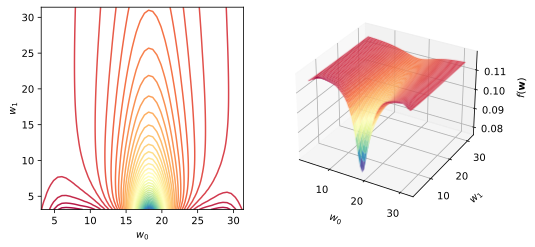

In [16]:
π = np.pi
grid_w = np.linspace(π,10*π,50)
#grid_w = np.linspace(π,5*π,50)
fig,ax,ax3d = ml4s.plot_2D_function(grid_w,grid_w,lambda w: C(w,δ,S))

In [17]:
N = δ.size
NB = 5
idδ = np.random.choice(N, NB, replace=False)
idδ

array([13, 76, 83, 97, 14])

In [18]:
#fig,ax,ax3d = ml4s.plot_2D_function(grid_w,grid_w,lambda w: C(w,δ,S))
# hyperparameters
η = 0.5
#Picked a starting point that looks closish to minimum.
w = np.array([18.0,5.0])

num_epoch = 50
num_batch = int(N/NB)

w_traj = np.zeros([num_epoch*num_batch,2])
w_traj[0,:] = w

C_traj = {}
C_traj['SGD'] = np.zeros([num_epoch*num_batch])

ax.plot(*w, marker='.', color='k', ms=15)  

# each epoch includes all minibatches
i = 0
for epoch in range(num_epoch):
    for batch in range(num_batch):

        # get the batch
        idδ = np.random.choice(N, NB, replace=False)
        
        # we keep a copy of the previous version for plotting
        w_old = np.copy(w)
        C_traj['SGD'][i] = C(w,δ,S)

        # perform the stocahstic GD update
        w += -η*dC_dw(w,δ[idδ],S[idδ])
        i += 1

In [19]:
def plot_trajectory(fig,ax,ax3d,w_traj,func,log_contours=False):
    '''Plot the trajectory of a minimization.'''
    
    num_iter = w_traj.shape[0]
    f_traj = np.array([func(w_traj[i,:]) for i in range(num_iter)])
    
    ax.plot(w_traj[0,0],w_traj[0,1], 'o', color='k', ms=6)    
    ax.plot(w_traj[:,0],w_traj[:,1], '.', color='k', ms=1)  
    
    if log_contours:
        f_traj = np.log(f_traj)
        
    ax3d.plot([w_traj[0,0]], [w_traj[0,1]], [f_traj[0]], marker='o', ms=6, linestyle='-', color='k',lw=1, zorder=100)
    ax3d.plot(w_traj[:,0], w_traj[:,1], f_traj, marker='.', ms=1, linestyle='-', color='k',lw=1, zorder=100)
    
    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$f(w) = {func(w):.6f}$', fontsize=14);
    
    return fig,ax,ax3d

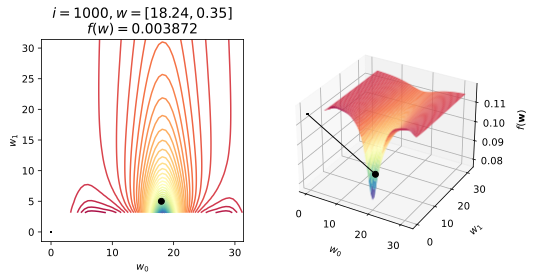

In [20]:
fig,ax,ax3d = ml4s.plot_2D_function(grid_w,grid_w,lambda w: C(w,δ,S))#,log_contours=True)
fig, ax, ax3d  = plot_trajectory(fig,ax,ax3d,w_traj,lambda w: C(w,δ,S))#,log_contours=True)

We observe a low cost function at 1000 iterations. With better choice of of starting position and increment, this could be significantly improved. However, this is efficient.

In [90]:
import json
with open("C60_optimal.json", "w") as f:
    json.dump({"alpha": 18.23,"beta": 0.42,"num_iter": 1000,"eta": 0.5},f,indent=4)

Added results into C60_optimal.json file.

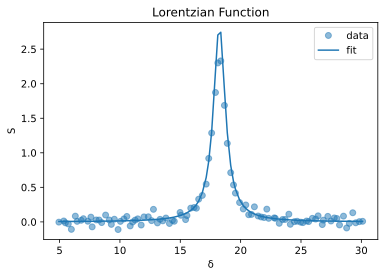

In [74]:
plt.plot(δ,S, 'o', label='data', alpha=0.5)
plt.plot(δ,Lorentz(δ,w),'-', label='fit', color=colors[0])
plt.xlabel('δ')
plt.ylabel('S')
plt.title('Lorentzian Function')
plt.legend()

We obtain a very nice fit!